## 06 - Example: financial data

In [1]:
import pandas as pd
data = pd.read_csv('financial_data.csv', index_col='Date')
data.index = pd.to_datetime(data.index, format='%d.%m.%y')

In [2]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1984-06-01,8.04,8.13,7.83,8.00,1.84,741000.0
1984-06-04,8.33,8.67,8.17,8.46,1.95,584700.0
1984-06-05,8.46,8.54,8.25,8.38,1.93,5370300.0
1984-06-06,8.38,8.54,8.38,8.54,1.97,365700.0
1984-06-07,8.54,8.58,8.46,8.54,1.97,904800.0


In [3]:
prices = data['Close']

In [4]:
prices.index

DatetimeIndex(['1984-06-01', '1984-06-04', '1984-06-05', '1984-06-06',
               '1984-06-07', '1984-06-08', '1984-06-11', '1984-06-12',
               '1984-06-13', '1984-06-14',
               ...
               '2020-08-17', '2020-08-18', '2020-08-19', '2020-08-20',
               '2020-08-21', '2020-08-24', '2020-08-25', '2020-08-26',
               '2020-08-27', '2020-08-28'],
              dtype='datetime64[ns]', name='Date', length=9137, freq=None)

In [5]:
prices['2012-01-01':'2012-04-01']

Date
2012-01-03    34.98
2012-01-04    34.95
2012-01-05    35.68
2012-01-06    35.36
2012-01-09    35.30
2012-01-10    36.05
2012-01-11    36.66
2012-01-12    36.85
2012-01-13    35.92
2012-01-17    34.91
2012-01-18    36.54
2012-01-19    36.93
2012-01-20    37.36
2012-01-23    37.66
2012-01-24    37.66
2012-01-25    37.60
2012-01-26    37.49
2012-01-27    37.21
2012-01-30    37.01
2012-01-31    37.30
2012-02-01    37.60
2012-02-02    37.55
2012-02-03    38.28
2012-02-06    38.14
2012-02-07    37.87
2012-02-08    38.30
2012-02-09    37.86
2012-02-10    37.61
2012-02-13    38.30
2012-02-14    37.92
              ...  
2012-02-17    38.47
2012-02-21    38.46
2012-02-22    38.07
2012-02-23    38.49
2012-02-24    38.28
2012-02-27    39.06
2012-02-28    39.21
2012-02-29    39.24
2012-03-01    40.37
2012-03-02    40.63
2012-03-05    40.40
2012-03-06    39.32
2012-03-07    39.95
2012-03-08    40.44
2012-03-09    41.03
2012-03-12    40.54
2012-03-13    43.39
2012-03-14    43.58
2012-03-15    4

C:\Users\Utilisateur\anaconda3v2\envs\exts-ml\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


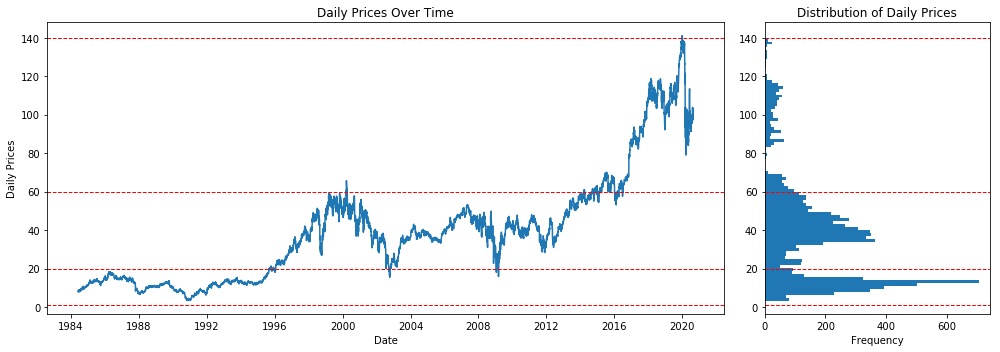

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the trend and histogram of prices together
# initialize two subplots in 1 row and two columns. Also specify the width of each plot
fig, ax = plt.subplots(1,2,figsize=(14, 5),gridspec_kw={'width_ratios': [3, 1]})

# create the first plot for the prices over time
ax[0].set_title('Daily Prices Over Time')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Daily Prices')
ax[0].plot(prices)
for i in [1,20,60,140]:
    ax[0].axhline(i,color='r', linewidth=1, linestyle='--')
    
# create the histogram of prices in the second plot
ax[1].set_title('Distribution of Daily Prices')
ax[1].set_xlabel('Frequency')
ax[1].hist(prices,bins=90,orientation='horizontal')
for i in [1,20,60,140]:
    ax[1].axhline(i,color='r', linewidth=1, linestyle='--')

fig.tight_layout()
plt.savefig('THUMB_PRICES.png')
plt.show()

## 07 - Shifting and computing first differences

In [7]:
Pt=prices['2019-12-15':'2019-12-30']
Pt

Date
2019-12-16    137.34
2019-12-17    138.18
2019-12-18    138.04
2019-12-19    137.35
2019-12-20    137.24
2019-12-23    137.20
2019-12-24    137.58
2019-12-26    139.04
2019-12-27    139.14
2019-12-30    138.63
Name: Close, dtype: float64

In [8]:
Pt.shift()

Date
2019-12-16       NaN
2019-12-17    137.34
2019-12-18    138.18
2019-12-19    138.04
2019-12-20    137.35
2019-12-23    137.24
2019-12-24    137.20
2019-12-26    137.58
2019-12-27    139.04
2019-12-30    139.14
Name: Close, dtype: float64

In [9]:
Pt.shift(-1)

Date
2019-12-16    138.18
2019-12-17    138.04
2019-12-18    137.35
2019-12-19    137.24
2019-12-20    137.20
2019-12-23    137.58
2019-12-24    139.04
2019-12-26    139.14
2019-12-27    138.63
2019-12-30       NaN
Name: Close, dtype: float64

In [10]:
p=pd.concat([Pt.shift(-1),Pt,Pt.shift(1),Pt.shift(2)],axis=1)
p.columns=['Pt+1', 'Pt','Pt-1','Pt-2']
print(p)

              Pt+1      Pt    Pt-1    Pt-2
Date                                      
2019-12-16  138.18  137.34     NaN     NaN
2019-12-17  138.04  138.18  137.34     NaN
2019-12-18  137.35  138.04  138.18  137.34
2019-12-19  137.24  137.35  138.04  138.18
2019-12-20  137.20  137.24  137.35  138.04
2019-12-23  137.58  137.20  137.24  137.35
2019-12-24  139.04  137.58  137.20  137.24
2019-12-26  139.14  139.04  137.58  137.20
2019-12-27  138.63  139.14  139.04  137.58
2019-12-30     NaN  138.63  139.14  139.04


#### Visualise effect on the time series

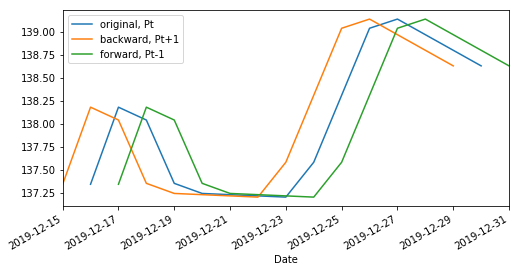

In [11]:
Pt.plot(figsize=(8, 3), label='original, Pt')
Pt.shift(-1,freq='D').plot(figsize=(8, 4), label='backward, Pt+1')
Pt.shift(1,freq='D').plot(figsize=(8, 4), label='forward, Pt-1')
plt.legend()
plt.show()

### Example - Analyzing the first difference

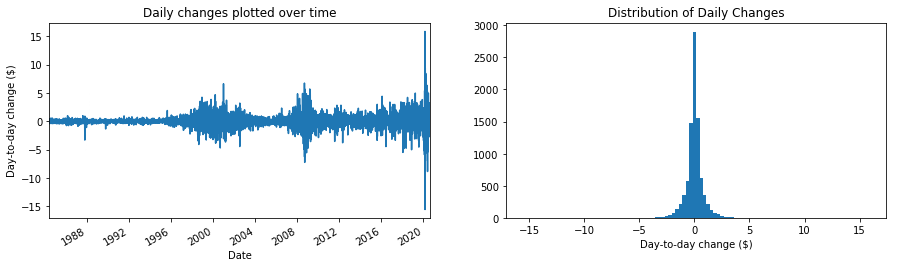

In [12]:
# Compute first difference
diff = prices - prices.shift(1)

# Plot the results

plt.subplot(121)
diff.plot(figsize=(15, 4))
plt.title('Daily changes plotted over time')
plt.ylabel('Day-to-day change ($)')

plt.subplot(122)
diff.hist(figsize=(15, 4),bins=100, grid=False)
plt.title('Distribution of Daily Changes')
plt.xlabel('Day-to-day change ($)')

plt.show()

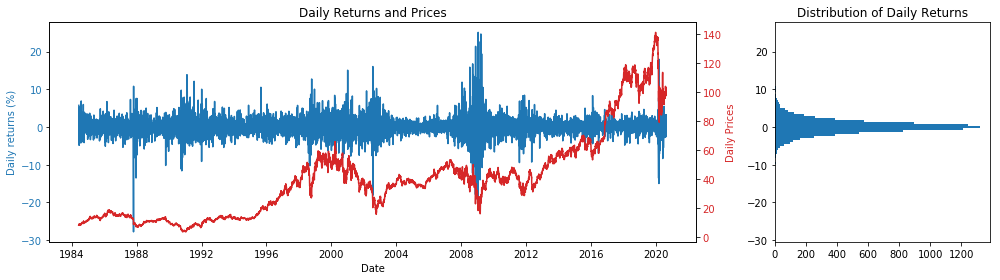

In [13]:
# Compute daily returns: divide the first difference by the price in the previous day
daily_percentage_change = 100*diff/prices.shift(1)

# drop the first value which is NaN
daily_percentage_change.dropna(inplace=True)

# Plot the results and original prices together
# initialize two subplots in 1 row and two columns. Also specify the width of each plot
fig, ax1 = plt.subplots(1,2,figsize=(14, 4),gridspec_kw={'width_ratios': [3, 1]})

# subplot for daily_percentage_change
color = 'tab:blue'
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel('Daily returns (%)', color=color)
ax1[0].plot(daily_percentage_change, color=color)
ax1[0].tick_params(axis='y', labelcolor=color)

# Create twin axes, so they can share the same xaxis, i.e. Dates
ax2 = ax1[0].twinx() 

# daily prices on the same subplot
color = 'tab:red'
ax2.set_ylabel('Daily Prices', color=color)
ax2.plot(prices, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Daily Returns and Prices')
 
# create the second subplot which is the histogram of daily_percentage_change
ax1[1].hist(daily_percentage_change,bins=100,orientation='horizontal')
ax1[1].set_title('Distribution of Daily Returns')

fig.tight_layout()
plt.show()

### Example - Return of investment

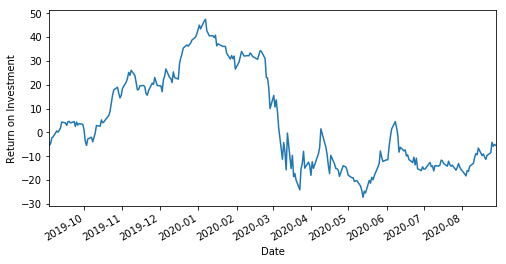

In [14]:
# Net profit over a year (in working days)
net_profit = prices-prices.shift(260)

# Return on Investment
roi = 100*net_profit/prices.shift(260)  

# Plot result
roi['2019-09-01':'2020-08-28'].plot(figsize=(8, 4))
plt.ylabel('Return on Investment')
plt.show()

### Appendix

In [15]:
Pt.diff(1)

Date
2019-12-16     NaN
2019-12-17    0.84
2019-12-18   -0.14
2019-12-19   -0.69
2019-12-20   -0.11
2019-12-23   -0.04
2019-12-24    0.38
2019-12-26    1.46
2019-12-27    0.10
2019-12-30   -0.51
Name: Close, dtype: float64

In [16]:
Pt-Pt.shift(1)

Date
2019-12-16     NaN
2019-12-17    0.84
2019-12-18   -0.14
2019-12-19   -0.69
2019-12-20   -0.11
2019-12-23   -0.04
2019-12-24    0.38
2019-12-26    1.46
2019-12-27    0.10
2019-12-30   -0.51
Name: Close, dtype: float64

In [17]:
Pt

Date
2019-12-16    137.34
2019-12-17    138.18
2019-12-18    138.04
2019-12-19    137.35
2019-12-20    137.24
2019-12-23    137.20
2019-12-24    137.58
2019-12-26    139.04
2019-12-27    139.14
2019-12-30    138.63
Name: Close, dtype: float64

In [18]:
Pt.shift(1)

Date
2019-12-16       NaN
2019-12-17    137.34
2019-12-18    138.18
2019-12-19    138.04
2019-12-20    137.35
2019-12-23    137.24
2019-12-24    137.20
2019-12-26    137.58
2019-12-27    139.04
2019-12-30    139.14
Name: Close, dtype: float64

In [19]:
Pt.shift(1, freq='B')

Date
2019-12-17    137.34
2019-12-18    138.18
2019-12-19    138.04
2019-12-20    137.35
2019-12-23    137.24
2019-12-24    137.20
2019-12-25    137.58
2019-12-27    139.04
2019-12-30    139.14
2019-12-31    138.63
Name: Close, dtype: float64

In [20]:
data=[1,2,'t',4]
indices=[4, 'Tokyo', 'blue', 'dog']
s=pd.Series(data, indices)
s

4        1
Tokyo    2
blue     t
dog      4
dtype: object

In [21]:
s.shift(1)

4        NaN
Tokyo      1
blue       2
dog        t
dtype: object

## 08 - Resampling and converting frequencies

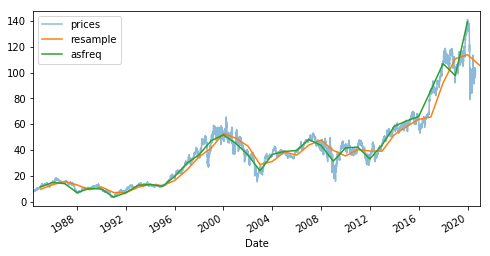

In [22]:
# Create the figure
plt.figure(figsize=(8, 4))

# Plot the prices
prices.plot(alpha=0.5)

# Downsampling - end of business year
# Variant 1: using resample()
prices.resample('BA').mean().plot()

# Variant 2: using asfreq()
prices.asfreq('BA').plot()

plt.legend(['prices', 'resample', 'asfreq'], loc='upper left')
plt.show()

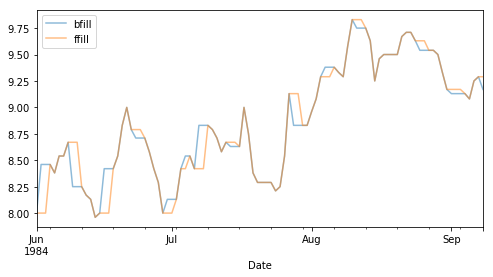

In [23]:
# Create the figure
plt.figure(figsize=(8, 4))

# Upsampling
# "backward fill" - fill missing with the closest value on the right
prices.asfreq('D', method='bfill')[0:100].plot(alpha=0.5)

# "forward fill" - fill missing with the closest value on the left
prices.asfreq('D', method='ffill')[0:100].plot(alpha=0.5)

plt.legend(['bfill', 'ffill'], loc='upper left')
plt.show()

In [24]:
from scipy.stats import skew,kurtosis
import numpy as np
# calculate skewness and kurtosis for the resampled data 
s,k=[],[]
for resamp in ['B','W','M','Q']:
    s.append(skew(prices.pct_change().resample(resamp).mean().dropna()))
    k.append(kurtosis(prices.pct_change().resample(resamp).mean().dropna()))

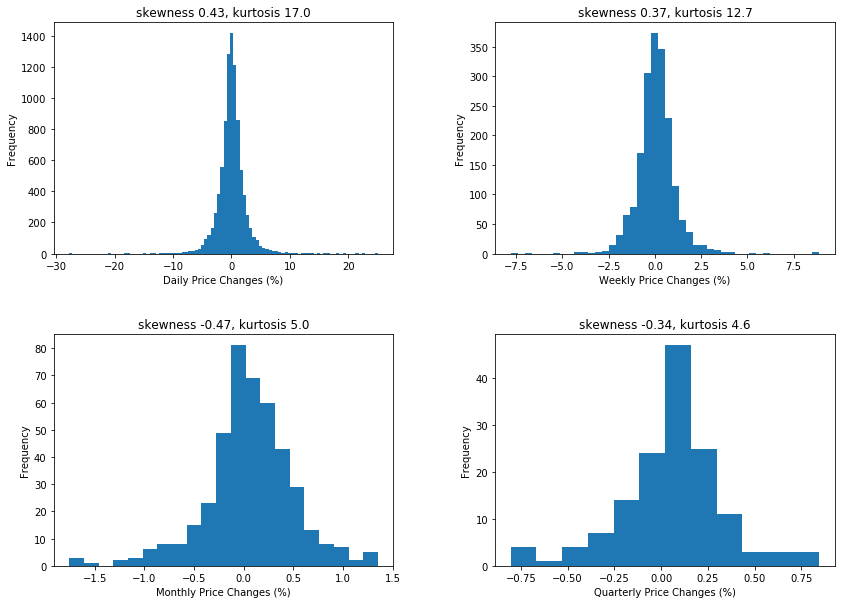

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), gridspec_kw={'hspace': 0.35, 'wspace': 0.3})

for (ax,resamp,freq,n_bin,i) in zip(axes.flatten(),
                                    ['B','W','M','Q'],                               
                                    ['Daily','Weekly','Monthly','Quarterly'],
                                    [96,44,21,12],
                                    [0,1,2,3]
                                   ):
    
    ax.hist(100*prices.pct_change().resample(resamp).mean(), n_bin)
    
    ax.set(xlabel = freq+' Price Changes (%)', 
           ylabel = 'Frequency',
           title  = 'skewness {:.2f}'.format(s[i])+
                    ', kurtosis {:.1f}'.format(3+k[i])
          )
plt.show()

## 09 - Rollings windows

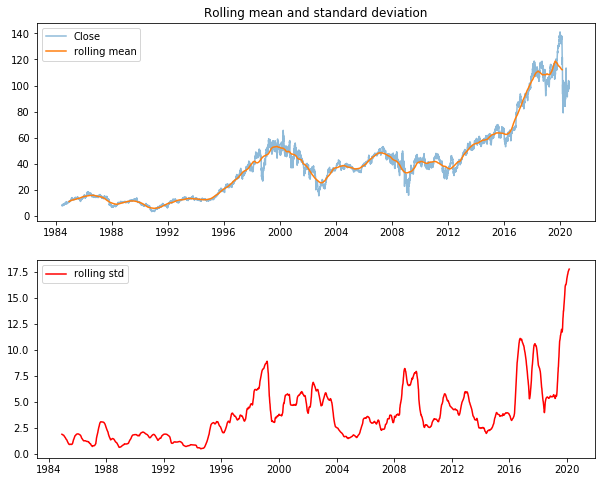

In [26]:
# Compute rolling mean and std
rolling_mean_1year = prices.rolling(260, center=True).mean()
rolling_std_1year = prices.rolling(260, center=True).std()

#Setup plot
fig, axes = plt.subplots(2, sharex=False, gridspec_kw={"height_ratios": (0.5, 0.5)}, figsize=(10,8))

# Plot rolling mean and std
axes[0].set_title('Rolling mean and standard deviation')
axes[0].plot(prices, alpha=0.5)
axes[0].plot(rolling_mean_1year, label='rolling mean')
axes[0].legend()
axes[1].plot(rolling_std_1year, c='red', label='rolling std')
axes[1].legend()
plt.show()

### Using rolling windows to detect outliers in time series

In [27]:
def detect_outliers_rolling(timeseries, days=10, n_std=2, center=False):

    rolling_mean = timeseries.rolling(window=days, center=center).mean()
    rolling_std = timeseries.rolling(window=days, center=center).std()
    lower_bound = rolling_mean - (n_std * rolling_std)
    upper_bound = rolling_mean + (n_std * rolling_std)

    # Identify outliers
    mask = (timeseries < lower_bound) | (timeseries > upper_bound)
    mask.sum()
    outliers = timeseries[mask]

    # Plot bounds and outliers
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, "lightblue", label="Time series")
    plt.plot(rolling_mean, "orange", label="Rolling mean")
    plt.plot(upper_bound, "r--", label="Bounds", alpha=0.5)
    plt.plot(lower_bound, "r--", label="", alpha=0.5)
    plt.plot(outliers, "ro", markersize=5, label="Outlier candidate")
    plt.legend(loc="best")
    plt.grid(True)
    plt.title(
        "{} outliers detected using a moving window of size = {}".format(
            len(outliers), days
        )
    )
    plt.show()

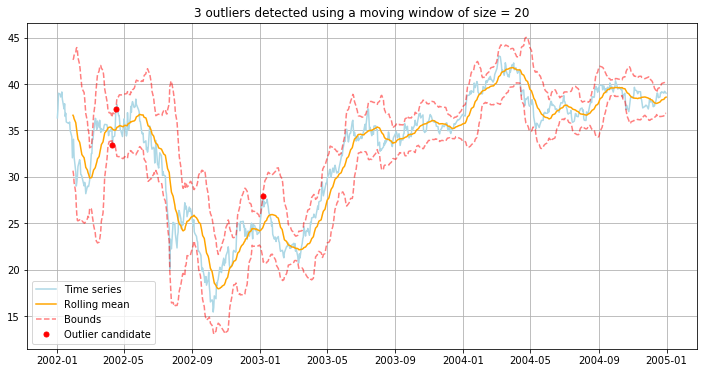

In [28]:
detect_outliers_rolling(prices['2002':'2004'], days=20, n_std=3, center=False)